In [1]:
# Standard imports
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from ieeg.auth import Session
from scipy import signal as sig
import scipy as sc
from itertools import compress

# ML Imports
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF,ConstantKernel
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize

# OS imports
import os
from os.path import join as ospj
from os.path import exists as ospe
import pathlib
from tqdm import tqdm
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
import mne

## Seizure Preprocessing

### Metadata table

In [2]:
metadata = pd.read_csv('../metadata.csv')
# (metadata.cceps_hfs_seizure == 1) | 
metadata = metadata[(metadata.cceps_run1_sz == 1)].reset_index()
metadata.loc[:,'ieeg_id'] = 'HUP' + metadata.hupsubjno.apply(str) + '_phaseII'
metadata.loc[:,'ccep_id'] = 'HUP' + metadata.hupsubjno.apply(str) + '_CCEP'
len(metadata)
metadata.head()

index  record_id  hupsubjno  ageatieegimplant ieeg_ictal_onset_electrodes  \
0     23      617.0        224              42.0               RB2, RB3, RC2   
1     24      700.0        225              33.0                    RT4, RT5   
2     26      835.0        229              40.0          LB1, LB2, LA1, LA2   
3     27      808.0        230              51.0     LC1, LC2, LC3, LB1, LB2   
4     28      796.0        235              24.0          LC1, LC2, LB2, LB3   

   ieeg_ictal_onset_anat_lat ieeg_ictal_onset_anat_spec  cceps_run1_home_meds  \
0                        2.0                hippocampus                   0.0   
1                        2.0         temporal neocortex                   0.0   
2                        1.0            mesial temporal                   1.0   
3                        1.0                hippocampus                   1.0   
4                        1.0      hippocampal tail/body                   1.0   

   cceps_run1_pulsewidth  cceps_run1_sz  ...  \
0                  300.0            1.0  ...   
1                  300.0            1.0  ...   
2                  300.0            1.0  ...   
3                  500.0            1.0  ...   
4                  500.0            1.0  ...   

                           cceps_run1_soz_electrodes  \
0  LB1, LB2, LB3, LB4, LB5, LC1, LC2, LC3, LC4, L...   
1                                 RB1, RB2, RB3, RB4   
2                            LB1, LB2, LC1, LC2, LC3   
3                                 LC1, LC2, LC3, LC4   
4  LA1, LA2, LA3, LB1, LB2, LB3, LC1, LC2, LC3, L...   

  cceps_run1_seizure_typical  cceps_hfs_done  cceps_hfs_seizure  \
0                        2.0             2.0                2.0   
1                        1.0             1.0                2.0   
2                        1.0             2.0                2.0   
3                        3.0             2.0                2.0   
4                        1.0             1.0                1.0   

   cceps_hfs_stim_elec_sz cceps_hfs_sz_typical  manual_reject_channels  \
0                     NaN                  NaN                     NaN   
1                     NaN                  NaN              RA09, RT01   
2                     NaN                  NaN                     NaN   
3                     NaN                  NaN               LB05,LB06   
4                     LA1                  1.0     LA01,LA02,LA04,LA05   

  final_reject_channels         ieeg_id      ccep_id  
0                   NaN  HUP224_phaseII  HUP224_CCEP  
1            RA09, RT01  HUP225_phaseII  HUP225_CCEP  
2                   NaN  HUP229_phaseII  HUP229_CCEP  
3             LB05,LB06  HUP230_phaseII  HUP230_CCEP  
4   LA01,LA02,LA04,LA05  HUP235_phaseII  HUP235_CCEP  

[5 rows x 21 columns]

In [3]:
metadata['manual_reject_channels'].fillna("",inplace=True)
metadata['manual_reject_channels'].str.split(",")

0                                                    []
1                                         [RA09,  RT01]
2                                                    []
3                                          [LB05, LB06]
4                              [LA01, LA02, LA04, LA05]
5     [LA04, LA05, LC02, LC03, LE01, LE02, LE03, LE0...
6                                                    []
7                                                    []
8                                          [RB01, RB02]
9                                          [LB03, LB04]
10                                         [RB02, RB03]
Name: manual_reject_channels, dtype: object

### Pulling patient metadata

In [4]:
def optimize_localizations(path_to_recon,RID):
    # /mnt/leif/littlab/data/Human_Data/recon/BIDS_penn/
    # python /mnt/leif/littlab/data/Human_Data/recon/code/run_penn_recons.py
    
    atropos_metadata = pd.read_json(path_to_recon + f'sub-RID0{RID}_ses-clinical01_space-T00mri_atlas-atropos_radius-2_desc-vox_coordinates.json',lines=True)
    localization_probs = pd.read_json(path_to_recon + f'sub-RID0{RID}_ses-clinical01_space-T00mri_atlas-DKTantspynet_radius-2_desc-vox_coordinates.json',lines=True)
    localization_metadata = pd.read_csv(path_to_recon + f'sub-RID0{RID}_ses-clinical01_space-T00mri_atlas-DKTantspynet_radius-2_desc-vox_coordinates.csv')
    def _apply_function(x):
        # look in labels sorted and see if it contains gray matter
        # if gray matter is greater than 5% then set label to gray matter
        x = pd.DataFrame(x).transpose()
        for i,label in enumerate(x['labels_sorted'].to_numpy()[0]):
            if (label == 'gray matter') and (x['percent_assigned'].to_numpy()[0][i] > 0.05):
                x['label'] = label
                x['index'] = 2
                continue
            elif (label == 'white matter') and (x['percent_assigned'].to_numpy()[0][i] > 0.05):
                x['label'] = label
                x['index'] = 3
        
        return x

    modified_atropos = atropos_metadata.iloc[:,:].apply(lambda x: _apply_function(x), axis = 1)
    modified_atropos_df = pd.DataFrame(np.squeeze(np.array(modified_atropos.to_list())),columns=atropos_metadata.columns)
    return modified_atropos_df

In [5]:
np.random.seed(42)
with open('config.json','r') as f:
    CONFIG = json.load(f)
usr = CONFIG["paths"]["iEEG_USR"]
pass_path = CONFIG["paths"]["iEEG_PWD"]
datapath = CONFIG["paths"]["RAW_DATA"]
ieeg_list = CONFIG["patients"]
rid_hup = pd.read_csv(ospj(datapath,'rid_hup.csv'))
pt_list = np.unique(np.array([i.split("_")[0] for i in ieeg_list]))
# Iterate through each patient
for pt in [pt_list[3]]:
    print(pt)
    raw_datapath = ospj(datapath,pt)
    # load dataframe of seizure times
    seizure_times = pd.read_csv(ospj(raw_datapath,f"seizure_times_{pt}.csv"))
    # load electrode information
    if not os.path.exists(ospj(raw_datapath, "electrode_localizations.csv")):
        hup_no = pt[3:]
        rid = rid_hup[rid_hup.hupsubjno == hup_no].record_id.to_numpy()[0]
        recon_path = ospj('/mnt','leif','littlab','data',
                          'Human_Data','CNT_iEEG_BIDS',
                          f'sub-RID0{rid}','derivatives','ieeg_recon',
                          'module3/')
        if not os.path.exists(recon_path):
            recon_path =  ospj('/mnt','leif','littlab','data',
                          'Human_Data','recon','BIDS_penn',
                          f'sub-RID0{rid}','derivatives','ieeg_recon',
                          'module3/')
        electrode_localizations = optimize_localizations(recon_path,rid)
        electrode_localizations.to_csv(ospj(raw_datapath,"electrode_localizations.csv"))
    else:    
        electrode_localizations = pd.read_csv(ospj(raw_datapath,"electrode_localizations.csv"))
    ch_names = electrode_localizations[(electrode_localizations['index'] == 2) | (electrode_localizations['index'] == 3)]["name"]
    ch_names_clean = clean_labels(ch_names,pt)
    
    # Changing dropping channel labels
    manual_drop_electrodes = clean_labels(metadata[metadata.hupsubjno == int(pt[-3:])]["manual_reject_channels"].str.split(',').to_list()[0],pt)
    final_drop_electrodes = clean_labels(metadata[metadata.hupsubjno == int(pt[-3:])]["final_reject_channels"].str.split(',').to_list()[0],pt)
    ch_names_clean = [ch for ch in ch_names_clean if ch not in final_drop_electrodes]
    if not os.path.exists(ospj(raw_datapath, "seizures")):
        os.mkdir(ospj(raw_datapath, "seizures"))

HUP235


### Pulling and saving seizures

Pipeline:
Pull raw seizure (plus 15 seconds prior to seizure onset)
if not stim:
    Detect bad channels (noisy, nans, zeros)
if lfstim:
    run detect bad channels and manually parse
    use manual stim rejection channels
if hf stim:
    reject stim channel
    Detect bad channels
Store detected bad channels in master dictionary
apply notch filter
apply bandpass filter (1-200)
run artifact detection algorithm
fill in individaul channels/gaps with artifact in them
make master list for channel masking


In [29]:
# Code for within each patient's for loop
for i_sz,row in seizure_times.iterrows():
    if i_sz != 8:
        continue
    if os.path.exists(ospj(raw_datapath,"seizures",f"seizure_{i_sz}_stim_{row.stim}.pkl")):
        buffered_seizure = pd.read_pickle(ospj(raw_datapath,"seizures",f"seizure_{i_sz}_stim_{row.stim}.pkl"))
        fs = buffered_seizure.fs.to_numpy()[-1]
        cols = buffered_seizure.columns
        buffer = buffered_seizure.loc[pd.isna(buffered_seizure.fs),ch_names_clean]
        seizure = buffered_seizure.loc[~pd.isna(buffered_seizure.fs),ch_names_clean]
        t = np.arange(0,len(seizure)/fs,1/fs)
        break
    # else:
    #     seizure,fs = get_iEEG_data(usr,pass_path,
    #                                 row.IEEGname,
    #                                 row.start*1e6,
    #                                 row.end*1e6,
    #                                 ch_names_clean,
    #                                 force_pull=True)
    #     t = np.arange(0,len(seizure)/fs,1/fs)
    #     save_seizure = pd.concat((seizure,pd.DataFrame(np.ones(len(seizure),)*fs,columns=['fs'])),axis = 1)
    #     save_seizure.to_pickle(ospj(raw_datapath,"seizures",f"seizure_{i_sz}_stim_{row.stim}.pkl"),index=False)
    #     break

In [30]:
metadata.head()

index  record_id  hupsubjno  ageatieegimplant ieeg_ictal_onset_electrodes  \
0     23      617.0        224              42.0               RB2, RB3, RC2   
1     24      700.0        225              33.0                    RT4, RT5   
2     26      835.0        229              40.0          LB1, LB2, LA1, LA2   
3     27      808.0        230              51.0     LC1, LC2, LC3, LB1, LB2   
4     28      796.0        235              24.0          LC1, LC2, LB2, LB3   

   ieeg_ictal_onset_anat_lat ieeg_ictal_onset_anat_spec  cceps_run1_home_meds  \
0                        2.0                hippocampus                   0.0   
1                        2.0         temporal neocortex                   0.0   
2                        1.0            mesial temporal                   1.0   
3                        1.0                hippocampus                   1.0   
4                        1.0      hippocampal tail/body                   1.0   

   cceps_run1_pulsewidth  cceps_run1_sz  ...  \
0                  300.0            1.0  ...   
1                  300.0            1.0  ...   
2                  300.0            1.0  ...   
3                  500.0            1.0  ...   
4                  500.0            1.0  ...   

                           cceps_run1_soz_electrodes  \
0  LB1, LB2, LB3, LB4, LB5, LC1, LC2, LC3, LC4, L...   
1                                 RB1, RB2, RB3, RB4   
2                            LB1, LB2, LC1, LC2, LC3   
3                                 LC1, LC2, LC3, LC4   
4  LA1, LA2, LA3, LB1, LB2, LB3, LC1, LC2, LC3, L...   

  cceps_run1_seizure_typical  cceps_hfs_done  cceps_hfs_seizure  \
0                        2.0             2.0                2.0   
1                        1.0             1.0                2.0   
2                        1.0             2.0                2.0   
3                        3.0             2.0                2.0   
4                        1.0             1.0                1.0   

   cceps_hfs_stim_elec_sz cceps_hfs_sz_typical  manual_reject_channels  \
0                     NaN                  NaN                           
1                     NaN                  NaN              RA09, RT01   
2                     NaN                  NaN                           
3                     NaN                  NaN               LB05,LB06   
4                     LA1                  1.0     LA01,LA02,LA04,LA05   

  final_reject_channels         ieeg_id      ccep_id  
0                   NaN  HUP224_phaseII  HUP224_CCEP  
1            RA09, RT01  HUP225_phaseII  HUP225_CCEP  
2                   NaN  HUP229_phaseII  HUP229_CCEP  
3             LB05,LB06  HUP230_phaseII  HUP230_CCEP  
4   LA01,LA02,LA04,LA05  HUP235_phaseII  HUP235_CCEP  

[5 rows x 21 columns]

In [31]:
[ch for ch in ch_names_clean if ch in manual_drop_electrodes]

[]

(<Figure size 499.967x1560 with 1 Axes>, <Axes: xlabel='Time (s)'>)

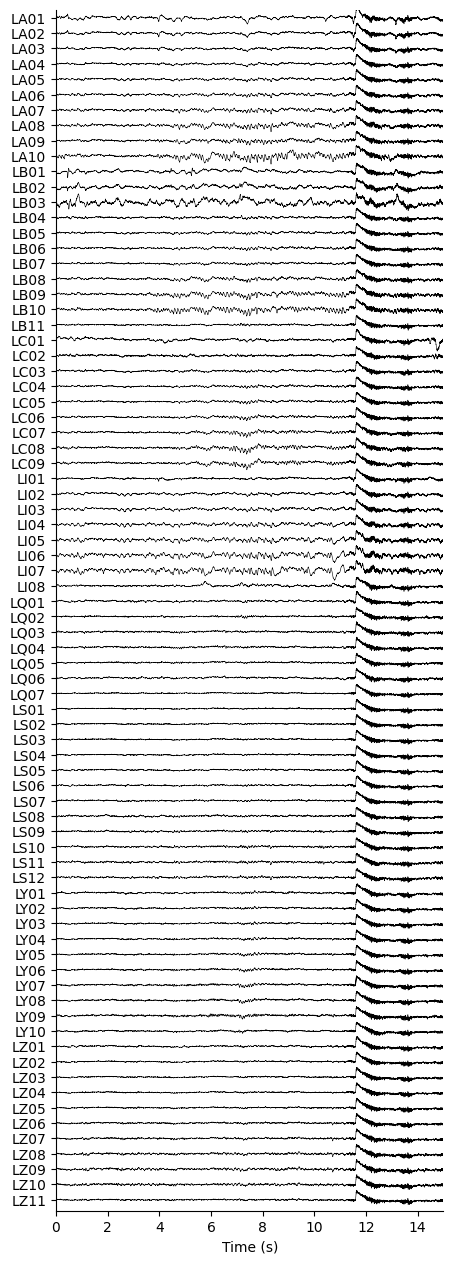

In [27]:
plot_iEEG_data(buffer,np.arange(0,len(buffer)/fs,1/fs))

(<Figure size 3439.97x1480 with 1 Axes>, <Axes: xlabel='Time (s)'>)

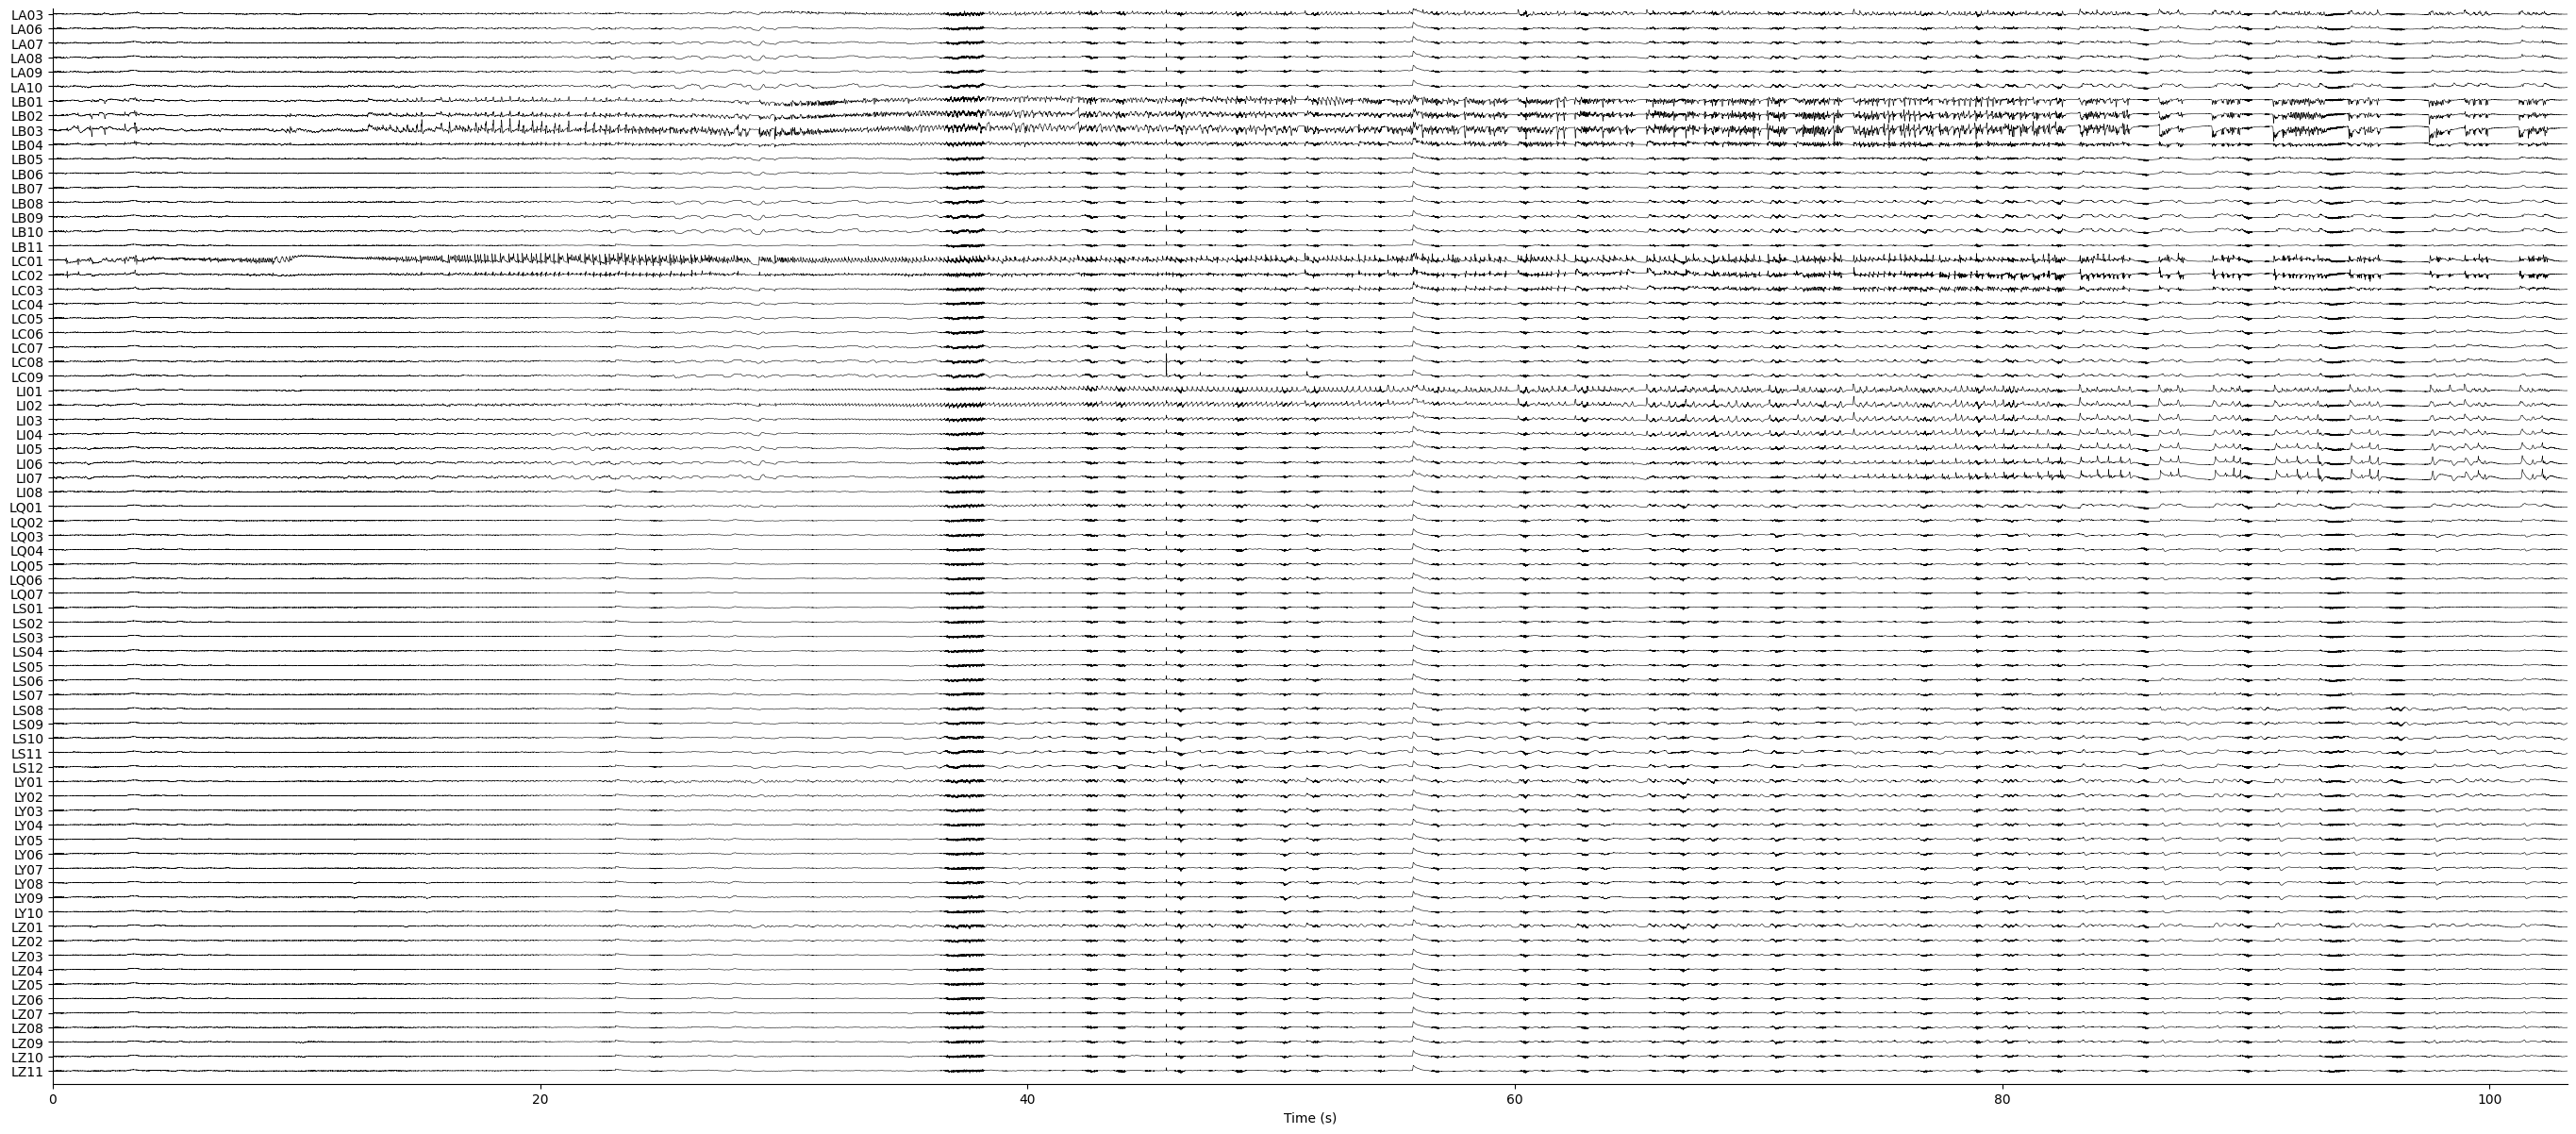

In [28]:
plot_iEEG_data(seizure,t)

### Channel Rejection

In [16]:
reject_mask,reject_details = detect_bad_channels(buffer.to_numpy(),fs,True)
print(reject_details)
np.where(~reject_mask)

{'noisy': [], 'nans': [], 'zeros': [], 'flat': [], 'var': [], 'higher_std': array([], dtype=int64), 'high_voltage': []}


(array([], dtype=int64),)

### Filtering

In [45]:
reject_mask,reject_details = detect_bad_channels(seizure.to_numpy(),fs)
processed_seizure = seizure.loc[:,reject_mask]
reject_details

{'noisy': [],
 'nans': [],
 'zeros': [],
 'flat': [],
 'var': [],
 'higher_std': array([], dtype=int64),
 'high_voltage': []}

In [41]:
ch_names_rejected = list(compress(ch_names_clean,reject_mask))


['LA03',
 'LA06',
 'LA07',
 'LA08',
 'LA09',
 'LA10',
 'LB01',
 'LB02',
 'LB03',
 'LB04',
 'LB05',
 'LB06',
 'LB07',
 'LB08',
 'LB09',
 'LB10',
 'LB11',
 'LC01',
 'LC02',
 'LC03',
 'LC04',
 'LC05',
 'LC06',
 'LC07',
 'LC08',
 'LC09',
 'LI01',
 'LI02',
 'LI03',
 'LI04',
 'LI05',
 'LI06',
 'LI07',
 'LI08',
 'LQ01',
 'LQ02',
 'LQ03',
 'LQ04',
 'LQ05',
 'LQ06',
 'LQ07',
 'LS01',
 'LS02',
 'LS03',
 'LS04',
 'LS05',
 'LS06',
 'LS07',
 'LS08',
 'LS09',
 'LS10',
 'LS11',
 'LS12',
 'LY01',
 'LY02',
 'LY03',
 'LY04',
 'LY05',
 'LY06',
 'LY07',
 'LY08',
 'LY09',
 'LY10',
 'LZ01',
 'LZ02',
 'LZ03',
 'LZ04',
 'LZ05',
 'LZ06',
 'LZ07',
 'LZ08',
 'LZ09',
 'LZ10',
 'LZ11']

In [44]:
# Here is where we need to add the mechanism to update the "total channel list" for all channels that work
# It will need to combine with the previously determined manual channels for the stim seizures
final_drop_electrodes += list(compress(ch_names_clean,~reject_mask))

[]

In [65]:
# plot_iEEG_data(seizure.iloc[:,reject_details['high_voltage']],t)

In [66]:
# notch_seizure = notch_filter(rseizure.to_numpy(),fs)
# band_seizure = bandpass_filter(notch_seizure,fs)
# # car_seizure = band_seizure - np.mean(band_seizure, axis=0)
# processed_seizure = pd.DataFrame(band_seizure,columns=rseizure.columns)

In [67]:
# plot_iEEG_data(processed_seizure,t)

### Stim Artifact Removal

In [68]:
def artifact_removal(
    data: np.ndarray, fs: float, discon=1 / 12, noise=15000, win_size=1
) -> np.ndarray:
    """_summary_

    Args:
        data pandas
        fs (float): _description_
        discon (_type_, optional): _description_. Defaults to 1/12.
        noise (int, optional): _description_. Defaults to 15000.
        win_size (int, optional): _description_. Defaults to 1.

    Returns:
        np.ndarray: _description_
    """
    win_size = int(win_size * fs)
    
    n_wins = np.ceil(data.shape[0]/win_size)
    max_inds = n_wins*win_size
     
    all_inds = np.arange(max_inds)
    all_inds[data.shape[0]:] = np.nan
    ind_overlap = np.reshape(all_inds, (-1, int(win_size)))
    
    artifacts = np.empty_like(data)

    # mask indices with nan values
    artifacts = np.isnan(data)

    for win_inds in ind_overlap:
        win_inds = win_inds[~np.isnan(win_inds)].astype(int)
        is_disconnected = np.sum(np.abs(data[win_inds,:]), axis=0) < discon

        is_noise = (
            np.sqrt(np.sum(np.power(np.diff(data[win_inds,:], axis=0), 2), axis=0))
            > noise
        )

        artifacts[win_inds, :] = np.logical_or(
            artifacts[win_inds, :].any(axis=0), np.logical_or(is_disconnected, is_noise)
        )

    return artifacts

In [116]:
art_idxs = artifact_removal(processed_seizure.to_numpy(),fs,win_size = .1,
                 noise = np.abs(np.mean(processed_seizure)) + 10*np.std(processed_seizure))

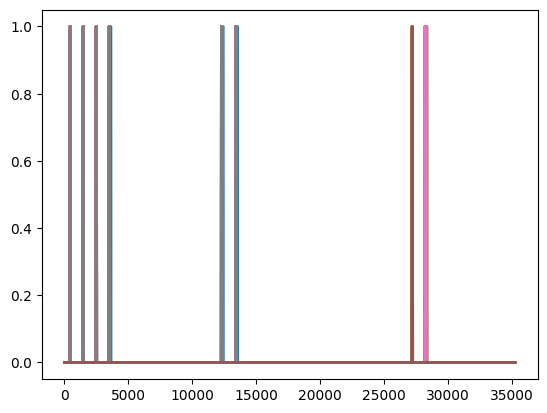

In [117]:
plt.figure();
plt.plot(art_idxs);

In [118]:
# artifact_mask = sig.medfilt(art_idxs.astype(int),(3,1))
# stim_idxs = [np.reshape(np.where(np.diff(artifact_mask[:,ch],prepend=0)),(-1,2))for ch in range(art_idxs.shape[1])]
artifact_mask = sig.medfilt(art_idxs.any(1).astype(int),5)
stim_idxs = np.reshape(np.where(np.diff(artifact_mask,prepend=0)),(-1,2))
s = processed_seizure.copy().to_numpy()



In [119]:
np.random.seed(42)
for i_ch in range(sum(reject_mask)):
    for win in stim_idxs:
        win_len = win[1]-win[0]
        pre_idx = win[0] - win_len
        post_idx = win[1] + win_len
        
        # Plotting raw signal
        plot_seg = processed_seizure.iloc[pre_idx:post_idx,i_ch].to_numpy()
        # plt.figure()
        # plt.plot(t[np.arange(pre_idx,post_idx)],plot_seg)
        # plt.vlines([(win_len + pre_idx)/fs, (2*win_len+pre_idx)/fs],plot_seg.min(),plot_seg.max())

        # Interpolation parameters
        pre_idxs = np.arange(pre_idx,win[0])
        post_idxs = np.arange(win[1],post_idx)
        fill_idxs = np.arange(win[0],win[1])

        # Interpolation
        interp_fn = sc.interpolate.interp1d(np.concatenate([t[pre_idxs],t[post_idxs]]),
                                np.concatenate([s[pre_idxs,i_ch],s[post_idxs,i_ch]]))
        filled_s = interp_fn(t[fill_idxs])

        # Adding noise to interpolation
        sample_std = (np.std(s[pre_idxs,i_ch]) + np.std(s[post_idxs,i_ch]))/8
        interp_samples = np.random.normal(filled_s,np.ones_like(filled_s)*sample_std)

        # # # Plotting interpolation
        # plt.figure()
        # plt.plot(t[pre_idxs],s[pre_idxs,i_ch],color='k')
        # plt.plot(t[fill_idxs],filled_s,color='r')
        # plt.plot(t[post_idxs],s[post_idxs,i_ch],color='k')
        # plt.plot(t[fill_idxs],sc.ndimage.gaussian_filter1d(interp_samples,2),color='b')
        
        s[win[0]:win[1],i_ch] = interp_samples



In [120]:
# cols = ch_names_clean
# cols.append('fs')
# postrejection_seizure = pd.DataFrame(np.concatenate((s,np.ones((len(s,),1))*fs),axis=1), columns = cols)

In [121]:
# postrejection_seizure.head()

In [122]:
# plot_iEEG_data(s,t)

In [125]:
notch_seizure = notch_filter(s,fs)
band_seizure = bandpass_filter(notch_seizure,fs)
car_seizure = band_seizure - np.mean(band_seizure, axis=0)
filtered_seizure = pd.DataFrame(car_seizure,columns=processed_seizure.columns)

(<Figure size 1146.65x3520 with 1 Axes>, <Axes: xlabel='Time (s)'>)

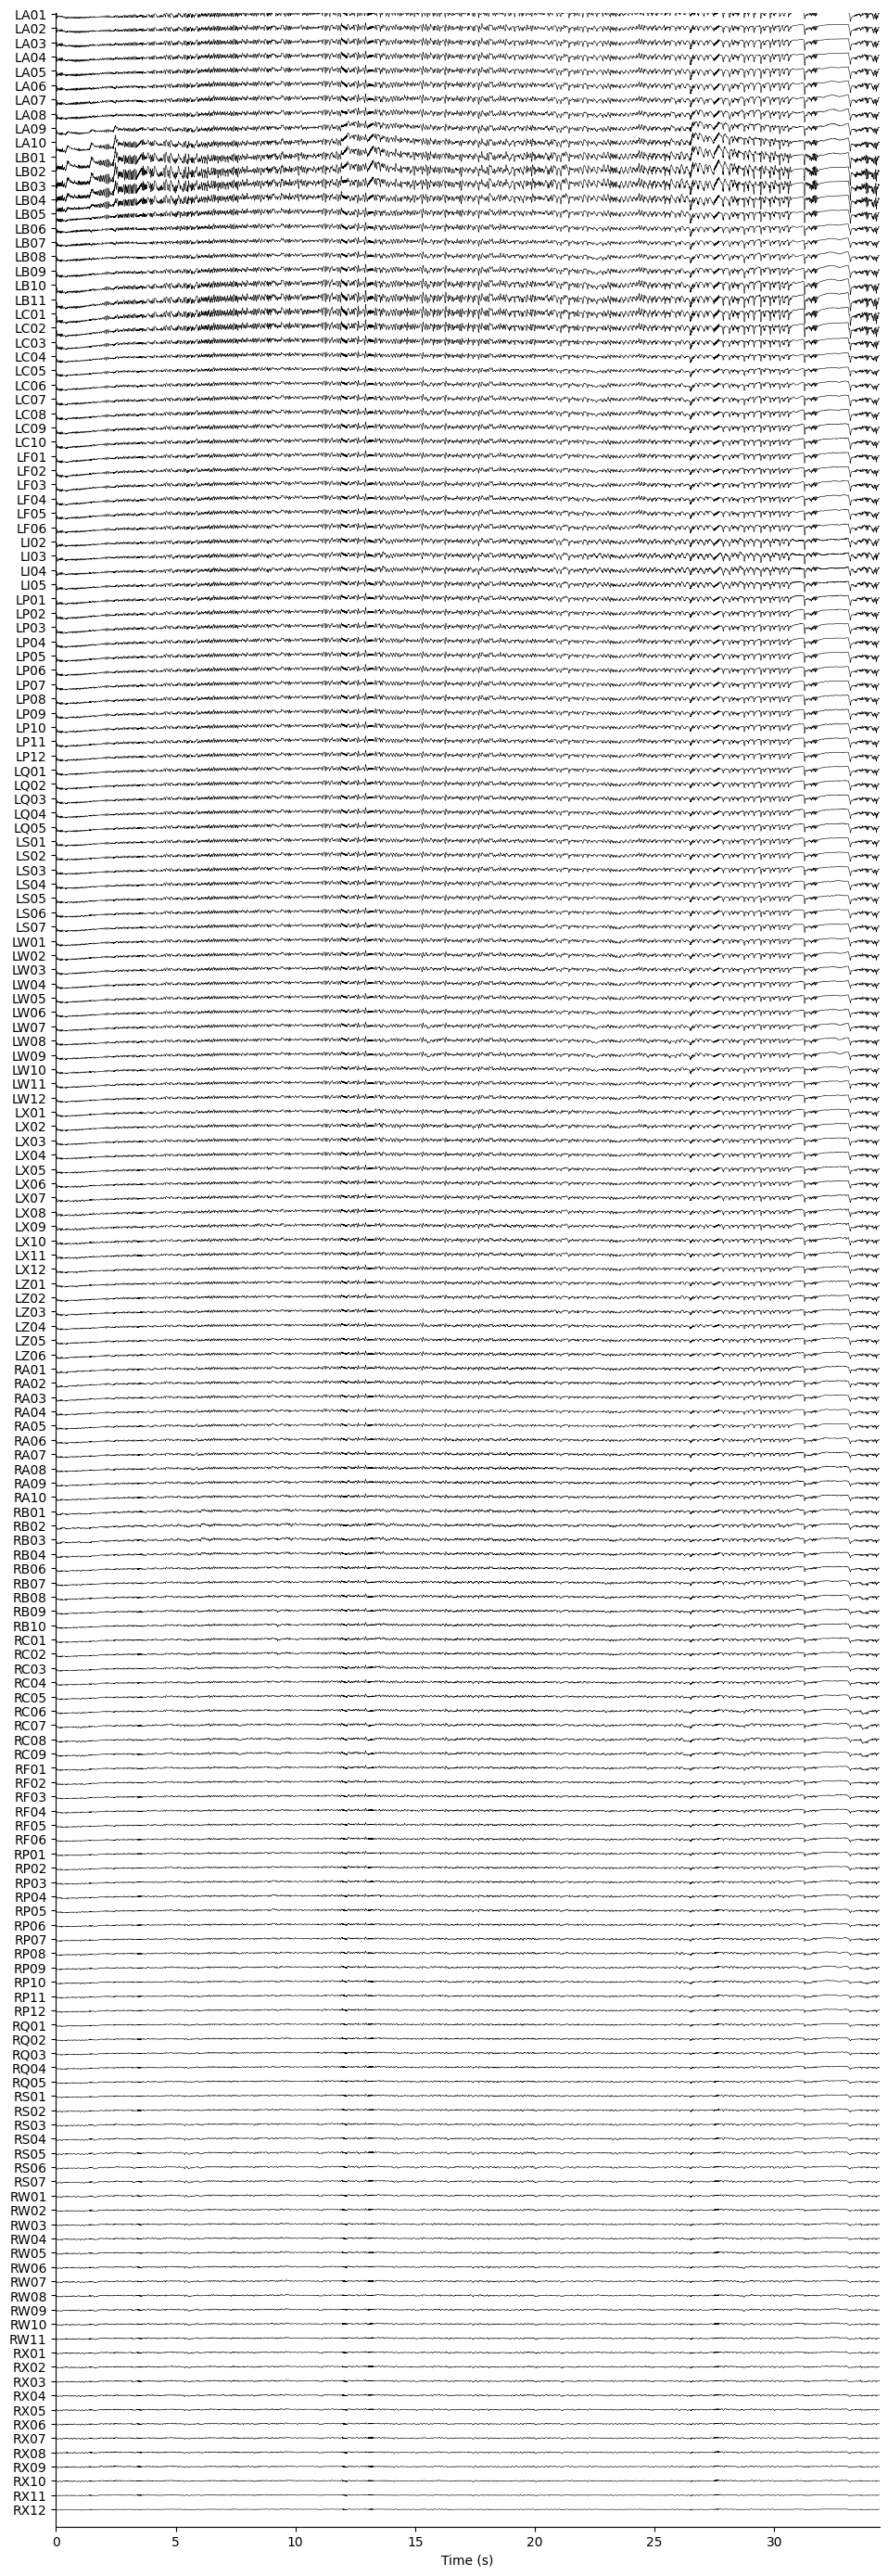

In [126]:
plot_iEEG_data(filtered_seizure,t)